> # Barcelona, pisos turísticos.
Queremos sacar los pisos turisticos que tienen licencia  y los que no , pero que están activos en Airbnb, ya que hay algunos pisos que salen en el dataSet pero que están inactivos y son antiguos
Despues sacaremos los hosts que tienen mas de 5 pisos en la plataforma, y los compararemos con el listado oficial de pisos turisticos de Barcelona para identificarlos y ponerlos en la visualizacion de otro color



In [10]:

!pip install pandas==1.2.4

In [11]:
!pip install seaborn

In [12]:
!pip install folium 
!pip install geopandas 


In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd
from branca.colormap import LinearColormap
import os



In [14]:
print(pd.__version__)

1.2.4


- Usaremos el dataset del Ayuntamiento de Barcelona
https://opendata-ajuntament.barcelona.cat/data/es/dataset/habitatges-us-turistic/resource/b32fa7f6-d464-403b-8a02-0292a64883bf

> # Viviendas de uso turístico de la ciudad de Barcelona. 4 Trimestre año 2022

https://opendata-ajuntament.barcelona.cat/data/dataset/c748799e-1079-44b1-9e60-88d936a3fe70/resource/b32fa7f6-d464-403b-8a02-0292a64883bf/download

Los datos de Airbnb los sacaremos de 
http://insideairbnb.com/barcelona/
11 December, 2022

Para que podamos trabajar con las tablas de Barcelona y Airbn tenemos que cambiar el nombre a alguna columna, como la de Districte, que en airbnb lo llama neighbourhood_group y neighbourhood
asi que  la decision es cual de las dos tablas lo cambiamos,optaremos por cambiarlo en la de airbnb para que se entienda mas que es un distrito y no un barri y asi dejar la de open data barcelona intacta. Posteriormente juntaremos todos los DataSets, pero antes sacaremosl a info de airbnb como -pisos disponibles activos 
- Tipo de licencia y si es una licencia valida o no 
- NUmero de pisos que tiene cada hosts.

para ello sacamos los pisos disponibles
y añadiremos una nueva columna para saber si es legal o ilegal.
Hay dos tipos de ilegalidades:
-el piso que directamente no tiene licencia ni indica que está exento
-el piso/habitacion que indica exento pero realmente no cumple la condidion por ley de que el alquiler sea mas de 30 dias
esta tipologia la indicaremos en una columna nueva


- Limpiaremos la tabla de OPenDataBarcelona quedandonos solo son los datos que vamos a utilizar en la visualizacion
    - Latitud / Longitud 
    - Districte
 
 - La de Airbnb Tb la LImpiaremos
     - neighbourhood
     - host-id
     - latitud - longitud ( nos interesa guardar los dos porque  no todos los pisos están en la base de datos del ayuntamiento y no todos los del ayuntamiento están en la base de datos de airbnb, luego al hacer merge ya veremos con que latitud y longitud nos quedamos.
     
     - minimo de noches 
     
     -last review
     - noches activas por año

In [38]:
airbnb = pd.read_csv("datasets/listings.csv", index_col= "id")
airbnb_details = pd.read_csv("datasets/listings_detailed.csv", index_col= "id", low_memory=False)

opendata =  pd.read_csv("datasets/hut_comunicacio.csv", low_memory=False)

In [39]:
opendata.head()

,N_EXPEDIENT,CODI_DISTRICTE,DISTRICTE,CODI_BARRI,BARRI,TIPUS_CARRER,CARRER,TIPUS_NUM,NUM1,LLETRA1,...,BLOC,PORTAL,ESCALA,PIS,PORTA,NUMERO_REGISTRE_GENERALITAT,NUMERO_PLACES,LONGITUD_X,LATITUD_Y,Unnamed: 21
0,01-2013-0753,1,CIUTAT VELLA,1.0,el Raval,Carrer,HOSPITAL,1,25,NaN,...,NaN,NaN,NaN,1,2,HUTB-000715,9,2.171125,41.379035,NaN
1,02-2014-0566,2,L'EIXAMPLE,6.0,la Sagrada Família,Avinguda,GAUDI,1,51,NaN,...,NaN,NaN,NaN,EN,1,HUTB-010412,7,2.173113,41.406595,NaN
2,02-2014-0207,2,L'EIXAMPLE,7.0,la Dreta de l'Eixample,Plaça,TETUAN,1,33,NaN,...,NaN,NaN,NaN,SA,2,HUTB-008754,4,2.174958,41.393788,NaN
3,01-2014-0073,1,CIUTAT VELLA,1.0,el Raval,Carrer,JUNTA DE COMERÇ,1,23,NaN,...,NaN,NaN,NaN,2,1A,HUTB-013228,4,2.170788,41.377598,NaN
4,02-2014-1125,2,L'EIXAMPLE,7.0,la Dreta de l'Eixample,Gran Via,CORTS CATALANES,2,682,NaN,...,NaN,NaN,NaN,2,1,HUTB-011029,8,2.171954,41.390836,NaN


,name,host_id,host_name,latitude,longitude
listing_id,,,,,
581637468287638346,R1Central room with a lot of tranquility and l...,367041953,Maria,41.394040,2.165390
615705584015659692,R2 Quiet and bright room in the center,367041953,Maria,41.395390,2.167650
615716756301189673,R3 Economic room for two people,367041953,Maria,41.393500,2.167320
617269759441347617,R4 Preciosa habitación en centro de Barcelona,367041953,Maria,41.393920,2.165850
747479942486204272,VAL3 Preciosa habitación con dos camas,367041953,Maria,41.381910,2.148720
747521971714654469,VAL4 Habitacion single en Barcelona,367041953,Maria,41.380360,2.148380
740363695968490088,T1 Acogedora habitación luminosa en el centro,367041953,Maria,41.393380,2.173950
747586973219251623,VAL5 Bonita habitación doble con balcón,367041953,Maria,41.380180,2.146970
740999249803710523,T2 Acogedora habitación triple con balcón,367041953,Maria,41.394900,2.175880


In [40]:
len(opendata_general)

9479

In [41]:
len(airbnb)

15778

# Reflexiones

### El numero de pisos que da un dataset y otro difiere, por qué? 

### hay mas pisos turisticos de lo que tiene registrado el ajuntament? habría manera de saber cuantos con el apo que nos da airbnb?

### Podremos tener información de los host de esos pisos?

### qué campo podría cruzar de una tabla y otra? Numero registro de la generalitat



Mezclamos las tablas de airbnb 

In [42]:
target_columns = ["listing_url", "description"]
airbnb_merge = pd.merge(airbnb, airbnb_details[target_columns], on='id', how='left')
airbnb_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15778 entries, 18674 to 778752108157383991
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            15769 non-null  object 
 1   host_id                         15778 non-null  int64  
 2   host_name                       15776 non-null  object 
 3   neighbourhood_group             15778 non-null  object 
 4   neighbourhood                   15778 non-null  object 
 5   latitude                        15778 non-null  float64
 6   longitude                       15778 non-null  float64
 7   room_type                       15778 non-null  object 
 8   price                           15778 non-null  int64  
 9   minimum_nights                  15778 non-null  int64  
 10  number_of_reviews               15778 non-null  int64  
 11  last_review                     12501 non-null  object 
 12  reviews_per_mon

### Cruzaremos las tablas con el numero de Registro

Refinamos la tabla y nos quedamos con las columnas que necesitamos

In [139]:
airbnb_merge = airbnb_merge[['listing_url','host_id','description','host_name','neighbourhood_group','latitude','longitude','minimum_nights','last_review','calculated_host_listings_count','availability_365', 'license']]
airbnb_merge.rename(columns = {'neighbourhood_group':'DISTRICTE'}, inplace = True)
airbnb_merge.rename(columns = {'license':'NUMERO_REGISTRE_GENERALITAT'}, inplace = True)
airbnb_merge['last_review'] = pd.to_datetime(airbnb_merge['last_review'], format='%')
airbnb_merge['DISTRICTE'] = airbnb_merge['DISTRICTE'].str.upper()
airbnb_merge.info()

KeyError: "['neighbourhood_group', 'license'] not in index"

In [135]:
airbnb_merge.columns

Index(['listing_url', 'host_id', 'description', 'host_name', 'DISTRICTE',
       'latitude', 'longitude', 'minimum_nights', 'last_review',
       'calculated_host_listings_count', 'availability_365',
       'NUMERO_REGISTRE_GENERALITAT'],
      dtype='object')

In [45]:
len(opendata)

9479

In [46]:
len(airbnb)

15778

In [47]:
airbnb_merge.head()

,listing_url,host_id,description,host_name,DISTRICTE,latitude,longitude,minimum_nights,last_review,calculated_host_listings_count,availability_365,NUMERO_REGISTRE_GENERALITAT
id,,,,,,,,,,,,
18674,https://www.airbnb.com/rooms/18674,71615,110m2 apartment to rent in Barcelona. Located ...,Mireia And Maria,EIXAMPLE,41.40556,2.17262,1,2022-10-07,20,264,HUTB-002062
23197,https://www.airbnb.com/rooms/23197,90417,"Beautiful spacious apartment, large terrace, 5...",Etain (Marnie),SANT MARTÍ,41.41243,2.21975,4,2022-10-23,2,255,HUTB005057
32711,https://www.airbnb.com/rooms/32711,135703,A lovely two bedroom apartment only 250 m from...,Nick,GRÀCIA,41.40566,2.17015,2,2022-12-09,3,276,HUTB-001722
34981,https://www.airbnb.com/rooms/34981,73163,Spacious apartment for large families or group...,Andres,CIUTAT VELLA,41.37978,2.17623,5,2022-11-19,1,139,HUTB-001506
36763,https://www.airbnb.com/rooms/36763,158596,<b>The space</b><br />Habitación con una cama ...,Ester,CIUTAT VELLA,41.38043,2.19094,31,2022-10-05,1,259,NaN


PREPARACIÓN DE TABLA AIRBNB
- filtramos las columnas QUE  necesitaremos
- cambiamos el nombre de neighbourhood a DISTRICTE
- limpiamos los valores nulos renombrandolos a Nulos y cambiando el tipo de columna a string
- cambiamos el tipo de columna last_review a date

Limpiamos los nulos. ( los Nulos son lo que no tienen reviews, los alojamientos que estan subidos a airbn pero que no están activos)
Tb hay nulos en numero de registro de generalitat , cambiaremos el valor de esas celdas a la palabra "Nulo" para saber ya que es una tipología de piso Nulo = Ilegal?



In [11]:
airbnb_merge.isnull().sum()

listing_url                          0
host_id                              0
description                         80
host_name                            2
DISTRICTE                            0
latitude                             0
longitude                            0
minimum_nights                       0
last_review                       3277
calculated_host_listings_count       0
availability_365                     0
NUMERO_REGISTRE_GENERALITAT       4974
dtype: int64

In [60]:
airbnb_merge['NUMERO_REGISTRE_GENERALITAT'] = airbnb_merge['NUMERO_REGISTRE_GENERALITAT'].fillna('Nulo')


#pisos activos , esto es super importante para descartar anuncios que no estan activos 


In [61]:
df_mask=airbnb_merge['NUMERO_REGISTRE_GENERALITAT']=='Nulo'

In [62]:
airbnf_nulos = airbnb_merge[df_mask]

In [63]:
len(airbnf_nulos)

4974

In [64]:
airbnf_nulos

,listing_url,host_id,description,host_name,DISTRICTE,latitude,longitude,minimum_nights,last_review,calculated_host_listings_count,availability_365,NUMERO_REGISTRE_GENERALITAT
id,,,,,,,,,,,,
36763,https://www.airbnb.com/rooms/36763,158596,<b>The space</b><br />Habitación con una cama ...,Ester,CIUTAT VELLA,41.380430,2.190940,31,2022-10-05,1,259,Nulo
363601,https://www.airbnb.com/rooms/363601,1837053,<b>The space</b><br />Recently refurbished thi...,Ayal,CIUTAT VELLA,41.379610,2.173060,32,2018-08-23,1,144,Nulo
68547,https://www.airbnb.com/rooms/68547,340570,The flat is located right in the historical ce...,Atún,CIUTAT VELLA,41.380600,2.177960,31,2021-08-10,2,303,Nulo
370665,https://www.airbnb.com/rooms/370665,1447144,vig HAPPY APARTMENT IN EL BORN IN THE OLD TOWN...,Acomodis Apartments,CIUTAT VELLA,41.385450,2.181170,32,2022-06-24,131,365,Nulo
383894,https://www.airbnb.com/rooms/383894,1751133,Loft Apartment in the center of Barcelona mixi...,The Punset Family,CIUTAT VELLA,41.388530,2.176040,32,2015-11-22,2,358,Nulo
...,...,...,...,...,...,...,...,...,...,...,...,...
767319539779305503,https://www.airbnb.com/rooms/767319539779305503,397090058,"The apartment has two bedrooms, one double bed...",Caterina,CIUTAT VELLA,41.382621,2.168380,32,NaT,12,88,Nulo
778130833512509902,https://www.airbnb.com/rooms/778130833512509902,180908619,Único por sus fantásticas vistas en centro de ...,Melissa,EIXAMPLE,41.403830,2.179120,31,NaT,9,359,Nulo
768043949839471987,https://www.airbnb.com/rooms/768043949839471987,224618386,Espectacular penthouse con terraza privada en ...,EnjoyBcn,EIXAMPLE,41.385580,2.164070,32,NaT,8,180,Nulo


Siva mos por ejemplo a este perfil https://www.airbnb.com/rooms/767319539779305503 veremos que está desactivado, de hecho el last_rwview es NaT cosa que ya nos da una pista de cuales tenemos que borrar


In [66]:
airbnb_merge.isnull().sum()

listing_url                          0
host_id                              0
description                         80
host_name                            2
DISTRICTE                            0
latitude                             0
longitude                            0
minimum_nights                       0
last_review                       3277
calculated_host_listings_count       0
availability_365                     0
NUMERO_REGISTRE_GENERALITAT          0
dtype: int64

In [177]:
#pisos activos , esto es super importante para descartar anuncios que no estan activos 
airbnb_merge_clean  =airbnb_merge.loc[  (airbnb_merge['last_review'].notnull()) &  (airbnb_merge['last_review'] > '2022-06-01') &  (airbnb_merge['availability_365'] > 20)]

In [178]:
airbnb_merge_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8810 entries, 18674 to 767951192535886373
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   listing_url                     8810 non-null   object        
 1   host_id                         8810 non-null   int64         
 2   description                     8787 non-null   object        
 3   host_name                       8810 non-null   object        
 4   DISTRICTE                       8810 non-null   object        
 5   latitude                        8810 non-null   float64       
 6   longitude                       8810 non-null   float64       
 7   minimum_nights                  8810 non-null   int64         
 8   last_review                     8810 non-null   datetime64[ns]
 9   calculated_host_listings_count  8810 non-null   int64         
 10  availability_365                8810 non-null   int64 

In [179]:
df_mask=airbnb_merge_clean['NUMERO_REGISTRE_GENERALITAT']=='Nulo'


In [180]:
airbnf_nulos = airbnb_merge_clean[df_mask]
airbnf_nulos

,listing_url,host_id,description,host_name,DISTRICTE,latitude,longitude,minimum_nights,last_review,calculated_host_listings_count,availability_365,NUMERO_REGISTRE_GENERALITAT
id,,,,,,,,,,,,
36763,https://www.airbnb.com/rooms/36763,158596,<b>The space</b><br />Habitación con una cama ...,Ester,CIUTAT VELLA,41.380430,2.190940,31,2022-10-05,1,259,Nulo
370665,https://www.airbnb.com/rooms/370665,1447144,vig HAPPY APARTMENT IN EL BORN IN THE OLD TOWN...,Acomodis Apartments,CIUTAT VELLA,41.385450,2.181170,32,2022-06-24,131,365,Nulo
384155,https://www.airbnb.com/rooms/384155,1751133,Minimum stay: 32 days. Apartment in the center...,The Punset Family,CIUTAT VELLA,41.384160,2.182570,32,2022-11-13,2,364,Nulo
136670,https://www.airbnb.com/rooms/136670,610674,The room is located very close to the universi...,Maria,LES CORTS,41.388320,2.122010,32,2022-10-31,3,232,Nulo
144471,https://www.airbnb.com/rooms/144471,700165,<b>The space</b><br />HELLO PEOPLE :=) <br />a...,Wonderful Barcelona,EIXAMPLE,41.381890,2.158570,3,2022-09-18,4,81,Nulo
...,...,...,...,...,...,...,...,...,...,...,...,...
718572283298019540,https://www.airbnb.com/rooms/718572283298019540,1093718,"Welcome to cozy and elegant apartment, locate...",Alexey,SANT MARTÍ,41.409560,2.186030,32,2022-10-31,12,176,Nulo
720755739774742889,https://www.airbnb.com/rooms/720755739774742889,131794,"Location, location, location!<br />In the beau...",Damien,EIXAMPLE,41.394150,2.171030,33,2022-11-05,23,295,Nulo
719654614117517084,https://www.airbnb.com/rooms/719654614117517084,2202284,This apartment is rented by months for up to 3...,Johanna,HORTA-GUINARDÓ,41.424190,2.139970,31,2022-11-15,17,126,Nulo


In [181]:
len(airbnf_nulos)


1470

In [182]:
len(airbnb_merge_clean)

8810

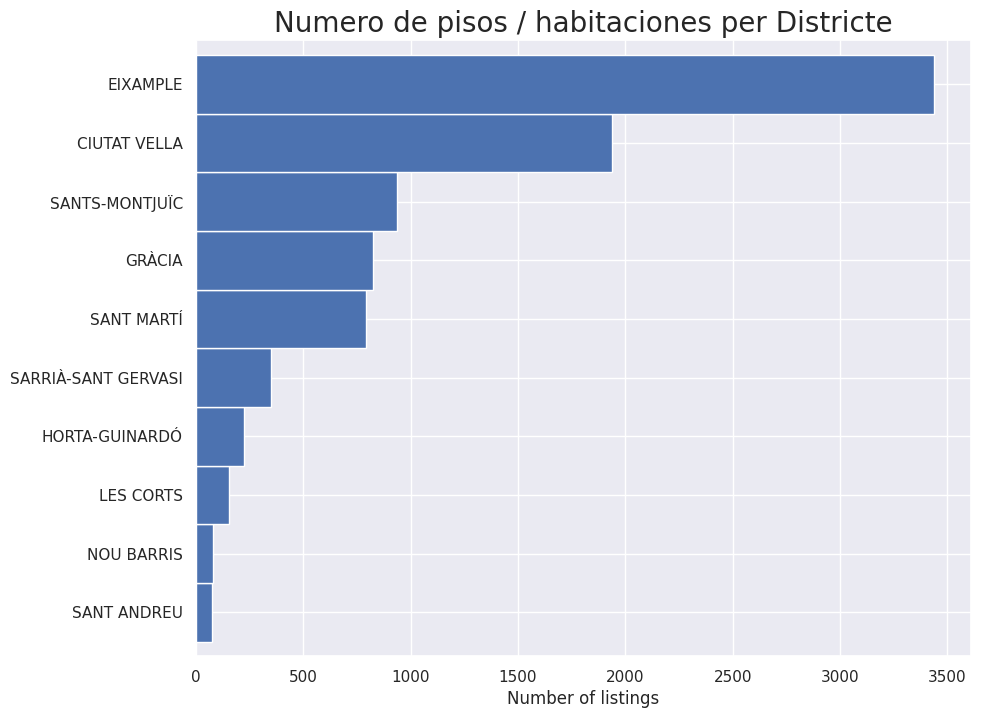

In [183]:
feq=airbnb_merge_clean['DISTRICTE'].value_counts().sort_values(ascending=True)
feq.plot.barh(figsize=(10, 8), color='b', width=1)
plt.title("Numero de pisos / habitaciones per Districte", fontsize=20)
plt.xlabel('Number of listings', fontsize=12)
plt.show()

In [184]:
lats2018 = airbnb_merge_clean['latitude'].tolist()
lons2018 = airbnb_merge_clean['longitude'].tolist()
lons_url = airbnb_merge_clean['listing_url'].tolist()
locations = list(zip(lats2018, lons2018))

map1 = folium.Map(location=[41.38879, 2.15899], zoom_start=11.5)
FastMarkerCluster(data=locations).add_to(map1)


m = folium.Map(location=[45.372, -121.6972], zoom_start=12, tiles="Stamen Terrain")
tooltip = "Click me!"
folium.Marker(
    [45.3288, -121.6625], popup="<i>Mt. Hood Meadows</i>", tooltip=tooltip
).add_to(m)
folium.Marker(
    [45.3311, -121.7113], popup="<b>Timberline Lodge</b>", tooltip=tooltip
).add_to(m)

m



map1

We see that neighbourhood_group is useless in Amsterdam, as it contains zero non-null objects. Below, I getting rid of this variable, and am showing the head of the dataframe that I am going to work with.

# 2. Exploración de datos
Tenemos una cantidad de pisos en Airbnb que están activos, son los que tienen mas de 20 dias de disponibilidad al año y que sus ultimos reviews son del año 2022




In [185]:
freq = airbnb_merge_clean.groupby(['host_id']).size().reset_index(name='calculated_host_listings_count')
host_prop = freq.groupby(['calculated_host_listings_count']).size().reset_index(name='count').transpose()
host_prop.columns = host_prop.iloc[0]
host_prop = host_prop.drop(host_prop.index[0])
host_prop

calculated_host_listings_count,1,2,3,4,5,6,7,8,9,10,...,39,42,43,54,61,94,106,118,119,171
count,2078,502,218,117,87,60,32,30,17,13,...,1,1,1,1,1,1,1,1,1,1


vamos a mezclar los datasets que tengan licencia turistica
dataframe avail con bcna .
para eso primero vamos a reemplazar los valores Nan por 0 de la licencia


In [186]:
bcna = airbnb_merge_clean.copy()

Tipo 0 - o indican la licencia y no entran dentro de alquiler por mas de 30 dias > posibles irregularidades en la licencia
Tipo 1 - Con licencia de piso/habitacion turistica

In [187]:
bcna["Tipo"] = bcna[["minimum_nights", "NUMERO_REGISTRE_GENERALITAT"]].apply(
    lambda x: "0" if (x.minimum_nights < 30  and x.NUMERO_REGISTRE_GENERALITAT == 'Nulo')
    else "1"
    if (x.minimum_nights < 30  and x.NUMERO_REGISTRE_GENERALITAT == 'Exempt')
    else "2"
    if (x.NUMERO_REGISTRE_GENERALITAT != "Nulo") & (x.NUMERO_REGISTRE_GENERALITAT != "Exempt")
    else "3", #los que están exentos, o nulos pero se alquilan en condiciones legales
    axis=1
)

bcna["TipoDescripcion"] = bcna[["minimum_nights", "NUMERO_REGISTRE_GENERALITAT"]].apply(
    lambda x: "Nulos-Ilegales" if (x.minimum_nights < 30  and x.NUMERO_REGISTRE_GENERALITAT == 'Nulo')
    else "Exentos ilegales"
    if (x.minimum_nights < 30  and x.NUMERO_REGISTRE_GENERALITAT == 'Exempt')
    else "Con Licenia"
    if (x.NUMERO_REGISTRE_GENERALITAT != "Nulo") & (x.NUMERO_REGISTRE_GENERALITAT != "Exempt")
    else "Exentos", #los que están exentos, o nulos pero se alquilan en condiciones legales
    axis=1
)

In [188]:
freq = bcna.groupby(['host_id']).size().reset_index(name='num_host_listings')
host_prop = freq.groupby(['num_host_listings']).size().reset_index(name='count').transpose()
host_prop.columns = host_prop.iloc[0]
host_prop = host_prop.drop(host_prop.index[0])
host_prop

num_host_listings,1,2,3,4,5,6,7,8,9,10,...,39,42,43,54,61,94,106,118,119,171
count,2078,502,218,117,87,60,32,30,17,13,...,1,1,1,1,1,1,1,1,1,1


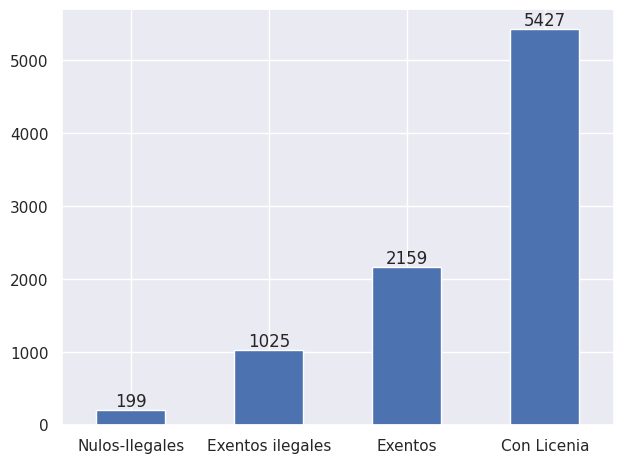

In [220]:
feq=bcna['TipoDescripcion'].value_counts().sort_values(ascending=True)
ax = feq.plot(x='Pillar', y='%', kind='bar', legend=False, rot=0)
ax.bar_label(ax.containers[0], label_type='edge')
plt.tight_layout()

In [228]:
bcna.loc[(bcna["Tipo"] == "2")]


,listing_url,host_id,description,host_name,DISTRICTE,latitude,longitude,minimum_nights,last_review,calculated_host_listings_count,availability_365,NUMERO_REGISTRE_GENERALITAT,Tipo,TipoDescripcion
id,,,,,,,,,,,,,,
18674,https://www.airbnb.com/rooms/18674,71615,110m2 apartment to rent in Barcelona. Located ...,Mireia And Maria,EIXAMPLE,41.405560,2.172620,1,2022-10-07,20,264,HUTB-002062,2,Con Licenia
23197,https://www.airbnb.com/rooms/23197,90417,"Beautiful spacious apartment, large terrace, 5...",Etain (Marnie),SANT MARTÍ,41.412430,2.219750,4,2022-10-23,2,255,HUTB005057,2,Con Licenia
32711,https://www.airbnb.com/rooms/32711,135703,A lovely two bedroom apartment only 250 m from...,Nick,GRÀCIA,41.405660,2.170150,2,2022-12-09,3,276,HUTB-001722,2,Con Licenia
34981,https://www.airbnb.com/rooms/34981,73163,Spacious apartment for large families or group...,Andres,CIUTAT VELLA,41.379780,2.176230,5,2022-11-19,1,139,HUTB-001506,2,Con Licenia
40983,https://www.airbnb.com/rooms/40983,177617,Our cool and comfortable one bedroom apartment...,Joaquin,EIXAMPLE,41.396310,2.168320,2,2022-11-29,6,267,HUTB-001282,2,Con Licenia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757259744857758526,https://www.airbnb.com/rooms/757259744857758526,436641358,Este alojamiento tiene una ubicación estratégi...,Artur,EIXAMPLE,41.385327,2.158140,1,2022-12-05,29,113,HUTB-273736,2,Con Licenia
757261202694290885,https://www.airbnb.com/rooms/757261202694290885,436641358,Disfruta de la comodidad de este alojamiento y...,Artur,EIXAMPLE,41.384964,2.158809,1,2022-11-28,29,112,HUTB-287362,2,Con Licenia
757654861138908193,https://www.airbnb.com/rooms/757654861138908193,3658157,Disfruta de la acogedora sencillez de este alo...,Vanessa,EIXAMPLE,41.402031,2.183445,1,2022-11-20,2,342,HUTB-009126,2,Con Licenia


In [191]:

districtes_barris =  pd.read_csv("datasets/districtes_i_barris_170705.csv")
districtes_barris['NOM_DISTRICTE'] = districtes_barris['NOM_DISTRICTE'].str.upper()

#districtes = districtes_barris.groupby(['NOM_DISTRICTE'])
districtes = districtes_barris.groupby(['NOM_DISTRICTE']).mean()
districtes = districtes.reset_index(level=0)

barris = districtes_barris.groupby(['NOM_BARRI']).mean()
barris = barris.reset_index(level=0)

In [192]:
##districtes = districtes.drop('CODI_BARRI', axis=1)


In [193]:
districtes_barris

,CODI_DISTRICTE,NOM_DISTRICTE,CODI_BARRI,NOM_BARRI
0,1,CIUTAT VELLA,1,el Raval
1,1,CIUTAT VELLA,2,el Barri Gòtic
2,1,CIUTAT VELLA,3,la Barceloneta
3,1,CIUTAT VELLA,4,"Sant Pere, Santa Caterina i la Ribera"
4,2,EIXAMPLE,5,el Fort Pienc
...,...,...,...,...
68,10,SANT MARTÍ,69,Diagonal Mar i el Front Marítim del Poblenou
69,10,SANT MARTÍ,70,el Besòs i el Maresme
70,10,SANT MARTÍ,71,Provençals del Poblenou
71,10,SANT MARTÍ,72,Sant Martí de Provençals


In [194]:
districtes['CODI_DISTRICTE'] = districtes['CODI_DISTRICTE'].astype(int)
# Sorting by column 'Country'
districtes.sort_values(by=['CODI_DISTRICTE'])


,NOM_DISTRICTE,CODI_DISTRICTE,CODI_BARRI
0,CIUTAT VELLA,1,2.5
1,EIXAMPLE,2,7.5
8,SANTS-MONTJUÏC,3,14.5
4,LES CORTS,4,20.0
9,SARRIÀ-SANT GERVASI,5,24.5
2,GRÀCIA,6,30.0
3,HORTA-GUINARDÓ,7,38.0
5,NOU BARRIS,8,50.0
6,SANT ANDREU,9,60.0
7,SANT MARTÍ,10,68.5


In [195]:
barris['CODI_BARRI'] = barris['CODI_BARRI'].astype(int)
# Sorting by column 'Country'
barris.sort_values(by=['CODI_BARRI'])


,NOM_BARRI,CODI_DISTRICTE,CODI_BARRI
45,el Raval,1,1
30,el Barri Gòtic,1,2
48,la Barceloneta,1,3
19,"Sant Pere, Santa Caterina i la Ribera",1,4
39,el Fort Pienc,2,5
...,...,...,...
5,Diagonal Mar i el Front Marítim del Poblenou,10,69
31,el Besòs i el Maresme,10,70
12,Provençals del Poblenou,10,71
18,Sant Martí de Provençals,10,72


In [196]:
districtes.rename(columns={"NOM_DISTRICTE": "DISTRICTE"}, inplace=True)
districtes.head()

,DISTRICTE,CODI_DISTRICTE,CODI_BARRI
0,CIUTAT VELLA,1,2.5
1,EIXAMPLE,2,7.5
2,GRÀCIA,6,30.0
3,HORTA-GUINARDÓ,7,38.0
4,LES CORTS,4,20.0


In [197]:

barris.head()

,NOM_BARRI,CODI_DISTRICTE,CODI_BARRI
0,Baró de Viver,9,58
1,Can Baró,7,34
2,Can Peguera,8,47
3,Canyelles,8,49
4,Ciutat Meridiana,8,55


In [198]:
districtes

,DISTRICTE,CODI_DISTRICTE,CODI_BARRI
0,CIUTAT VELLA,1,2.5
1,EIXAMPLE,2,7.5
2,GRÀCIA,6,30.0
3,HORTA-GUINARDÓ,7,38.0
4,LES CORTS,4,20.0
5,NOU BARRIS,8,50.0
6,SANT ANDREU,9,60.0
7,SANT MARTÍ,10,68.5
8,SANTS-MONTJUÏC,3,14.5
9,SARRIÀ-SANT GERVASI,5,24.5


In [199]:
bcna_clean_location = pd.merge(bcna, districtes, on='DISTRICTE', how='left')

In [200]:
#bcna_clean_location_barrio = pd.merge(bcna, barris, on='CODI_BARRI', how='left')

In [201]:
bcna_clean_location.head()

,listing_url,host_id,description,host_name,DISTRICTE,latitude,longitude,minimum_nights,last_review,calculated_host_listings_count,availability_365,NUMERO_REGISTRE_GENERALITAT,Tipo,TipoDescripcion,CODI_DISTRICTE,CODI_BARRI
0,https://www.airbnb.com/rooms/18674,71615,110m2 apartment to rent in Barcelona. Located ...,Mireia And Maria,EIXAMPLE,41.40556,2.17262,1,2022-10-07,20,264,HUTB-002062,2,Con Licenia,2,7.5
1,https://www.airbnb.com/rooms/23197,90417,"Beautiful spacious apartment, large terrace, 5...",Etain (Marnie),SANT MARTÍ,41.41243,2.21975,4,2022-10-23,2,255,HUTB005057,2,Con Licenia,10,68.5
2,https://www.airbnb.com/rooms/32711,135703,A lovely two bedroom apartment only 250 m from...,Nick,GRÀCIA,41.40566,2.17015,2,2022-12-09,3,276,HUTB-001722,2,Con Licenia,6,30.0
3,https://www.airbnb.com/rooms/34981,73163,Spacious apartment for large families or group...,Andres,CIUTAT VELLA,41.37978,2.17623,5,2022-11-19,1,139,HUTB-001506,2,Con Licenia,1,2.5
4,https://www.airbnb.com/rooms/36763,158596,<b>The space</b><br />Habitación con una cama ...,Ester,CIUTAT VELLA,41.38043,2.19094,31,2022-10-05,1,259,Nulo,3,Exentos,1,2.5


In [202]:
filepath2 = ('out/bcna_clean_location.csv')
districtes_file =  ('datasets/districtes.csv')
bcna_clean_location.to_csv(filepath2) 
districtes.to_csv(districtes_file) 

In [203]:
exentos =bcna_clean_location.loc[(bcna_clean_location["Tipo"] == "1")]

In [204]:
example = exentos.loc[(exentos["DISTRICTE"] == "EIXAMPLE")]
example

,listing_url,host_id,description,host_name,DISTRICTE,latitude,longitude,minimum_nights,last_review,calculated_host_listings_count,availability_365,NUMERO_REGISTRE_GENERALITAT,Tipo,TipoDescripcion,CODI_DISTRICTE,CODI_BARRI
18,https://www.airbnb.com/rooms/379868,1906952,Ubicación excepcional! ¡Magnífica vista del ic...,Khris,EIXAMPLE,41.405500,2.171240,3,2022-10-30,2,31,Exempt,1,Exentos ilegales,2,7.5
108,https://www.airbnb.com/rooms/568129,2795488,Rent for 31 days room with private bathroom. ...,Zulma,EIXAMPLE,41.381920,2.155630,5,2022-12-04,2,339,Exempt,1,Exentos ilegales,2,7.5
112,https://www.airbnb.com/rooms/568185,2795488,Rent for 31 days room with private bathroom. ...,Zulma,EIXAMPLE,41.381900,2.154190,5,2022-11-14,2,357,Exempt,1,Exentos ilegales,2,7.5
165,https://www.airbnb.com/rooms/600590,1906952,Ubicación excepcional! Frente al ícono artísti...,Khris,EIXAMPLE,41.405050,2.172590,3,2022-11-22,2,58,Exempt,1,Exentos ilegales,2,7.5
244,https://www.airbnb.com/rooms/866315,4427588,Wonderful guest suite with private terrace and...,David,EIXAMPLE,41.397650,2.162610,3,2022-12-05,1,282,Exempt,1,Exentos ilegales,2,7.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8801,https://www.airbnb.com/rooms/771024325698378340,367041953,Disfruta de la sencillez de este alojamiento t...,Maria,EIXAMPLE,41.388829,2.157130,1,2022-12-09,20,318,Exempt,1,Exentos ilegales,2,7.5
8802,https://www.airbnb.com/rooms/759265076926225052,13530812,Catalunya square flat heart of Barcelona<br />...,Lili,EIXAMPLE,41.386150,2.166040,4,2022-11-28,18,343,Exempt,1,Exentos ilegales,2,7.5
8803,https://www.airbnb.com/rooms/759655833006510622,394998732,Este alojamiento tiene una ubicación estratégi...,Antonio,EIXAMPLE,41.386272,2.165836,5,2022-11-21,12,341,Exempt,1,Exentos ilegales,2,7.5
8805,https://www.airbnb.com/rooms/765310137838070185,13530812,Enjoy barcelona living in the center !<br /><b...,Lili,EIXAMPLE,41.386234,2.167918,5,2022-11-29,18,343,Exempt,1,Exentos ilegales,2,7.5


In [205]:
bcna_clean_location.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8810 entries, 0 to 8809
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   listing_url                     8810 non-null   object        
 1   host_id                         8810 non-null   int64         
 2   description                     8787 non-null   object        
 3   host_name                       8810 non-null   object        
 4   DISTRICTE                       8810 non-null   object        
 5   latitude                        8810 non-null   float64       
 6   longitude                       8810 non-null   float64       
 7   minimum_nights                  8810 non-null   int64         
 8   last_review                     8810 non-null   datetime64[ns]
 9   calculated_host_listings_count  8810 non-null   int64         
 10  availability_365                8810 non-null   int64         
 11  NUME

## Hosts dudosisimos

In [217]:
#Detalles de un host:
host = bcna_clean_location[bcna_clean_location['host_id']== 370718107]
#host = host[['name','host_id', 'host_name', 'latitude', 'longitude']]
host.index.name = "listing_id"
host

,listing_url,host_id,description,host_name,DISTRICTE,latitude,longitude,minimum_nights,last_review,calculated_host_listings_count,availability_365,NUMERO_REGISTRE_GENERALITAT,Tipo,TipoDescripcion,CODI_DISTRICTE,CODI_BARRI
listing_id,,,,,,,,,,,,,,,,
5428,https://www.airbnb.com/rooms/45733680,370718107,Magnificent designer apartment located in the ...,Alexandre,CIUTAT VELLA,41.384500,2.180150,30,2022-09-15,42,238,Exempt,3,Exentos,1,2.5
5583,https://www.airbnb.com/rooms/46324039,370718107,2 bedroom apartment for 6 people next to the S...,Alexandre,GRÀCIA,41.404510,2.171830,1,2022-11-28,42,324,HUTB-009986,2,Con Licenia,6,30.0
5617,https://www.airbnb.com/rooms/46719525,370718107,"Superb penthouse with 3 bedrooms, 2 bathrooms ...",Alexandre,SANTS-MONTJUÏC,41.372700,2.149880,1,2022-12-11,42,194,HUTB-008036,2,Con Licenia,3,14.5
5713,https://www.airbnb.com/rooms/47984242,370718107,Large designer apartment in the center of Barc...,Alexandre,EIXAMPLE,41.381460,2.159430,1,2022-12-04,42,283,HUTB-003393,2,Con Licenia,2,7.5
5928,https://www.airbnb.com/rooms/49844110,370718107,2 bedroom apartment for 4 people next to Sant ...,Alexandre,EIXAMPLE,41.376520,2.161880,1,2022-12-11,42,269,HUTB-010288,2,Con Licenia,2,7.5
5929,https://www.airbnb.com/rooms/49844389,370718107,Bright apartment for 4 people. Situated in the...,Alexandre,SANTS-MONTJUÏC,41.374510,2.162970,1,2022-11-11,42,203,Exempt,1,Exentos ilegales,3,14.5
6020,https://www.airbnb.com/rooms/50320452,370718107,Modern apartment with 2 bedrooms and 1 bathroo...,Alexandre,SANTS-MONTJUÏC,41.370880,2.129170,1,2022-12-11,42,308,Nulo,0,Nulos-Ilegales,3,14.5
6110,https://www.airbnb.com/rooms/51005720,370718107,"Beautiful apartment with superb terrace, close...",Alexandre,SANT MARTÍ,41.396450,2.191700,1,2022-08-26,42,351,HUTB-012987,2,Con Licenia,10,68.5
6451,https://www.airbnb.com/rooms/52872928,370718107,Superb one bedroom apartment with terrace clos...,Alexandre,SANTS-MONTJUÏC,41.372850,2.168400,1,2022-12-06,42,324,HUTB-004413,2,Con Licenia,3,14.5


In [231]:
#exentos.to_csv('out/exentos ilegales_tipo1.csv') 
nulos =bcna_clean_location.loc[(bcna_clean_location["Tipo"] == "0")]
nulos.to_csv('out/nulos.csv') 


In [232]:
len(nulos)

199

se nos han colado estas filas en ilegales cuando son nulos?


https://meet.barcelona.cat/habitatgesturistics/

In [212]:
exentos_legales =bcna_clean_location.loc[(bcna_clean_location["Tipo"] == "2") ]
exentos_legales.head()
len(exentos_legales)
exentos_legales.to_csv('out/exentos legales_tipo2.csv') 

In [208]:
len(exentos_legales)

5427

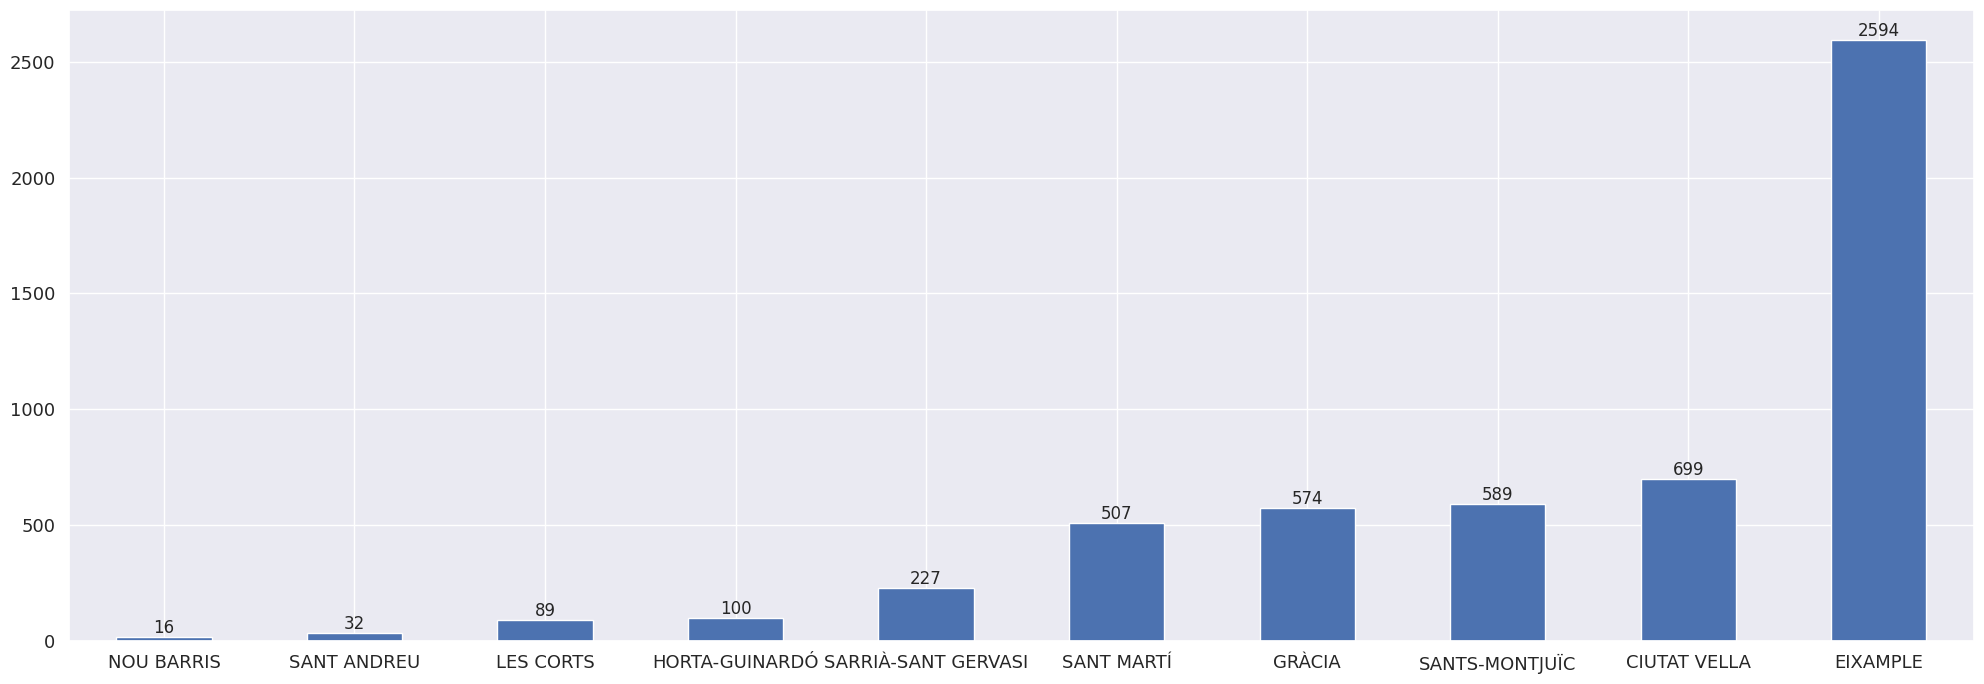

In [209]:
por_districtes_exentos=exentos_legales['DISTRICTE'].value_counts().sort_values(ascending=True)
ax = por_districtes_exentos.plot(x='Pillar', y='%', kind='bar', legend=False, rot=0, figsize=(20,7), fontsize=13)
ax.bar_label(ax.containers[0], label_type='edge')
plt.tight_layout()

Detalles de los comentarios / reviews

Text data mining


<div style="height: 75vh; width: 90%; margin: auto;"><iframe width="100%" height="100%" frameborder="0" scrolling="no" marginheight="0" marginwidth="0" src="https://www.instamaps.cat/visor.html?businessid=96a745b6f6d78e91bc6c531685310a7b&3D=false&embed=1" ></iframe></div>


In [214]:
pip install IFrame

ERROR: Could not find a version that satisfies the requirement IFrame (from versions: none)
ERROR: No matching distribution found for IFrame
Note: you may need to restart the kernel to use updated packages.


In [213]:
from IPython.display import IFrame
plot_fn = '<div style="height: 75vh; width: 90%; margin: auto;"><iframe width="100%" height="100%" frameborder="0" scrolling="no" marginheight="0" marginwidth="0" src="https://www.instamaps.cat/visor.html?businessid=96a745b6f6d78e91bc6c531685310a7b&3D=false&embed=1" ></iframe></div>
'
IFrame(plot_fn, width=600, height=400)

SyntaxError: unterminated string literal (detected at line 2) (811492355.py, line 2)